Copyright (c) 2021, salesforce.com, inc.  
All rights reserved.  
SPDX-License-Identifier: BSD-3-Clause  
For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause

# This notebook will be used to gather real-world data and perform data processing in order to use it in the covid-19 simulation.

### All the downloaded data will be formatted into pandas dataframes.

## Below is the list of COVID-19 data sources used in this notebook

1. **US state government policies** (Oxford Covid-19 Government Response Tracker (OxCGRT))

    https://github.com/OxCGRT/USA-covid-policy


2. **US federal government direct payments** (Committee for a Responsible Federal Budget)

    https://www.covidmoneytracker.org/
    
    https://docs.google.com/spreadsheets/d/1Nr_J5wLfUT4IzqSXkYbdOXrRgEkBxhX0/edit#gid=682404301
    

3. **US deaths data** (COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University)

    https://github.com/CSSEGISandData/COVID-19


4. **US vaccinations** (Our World in Data)
    
    https://ourworldindata.org/covid-vaccinations
    
    
5. **US unemployment** (Bureau of Labor and Statistics)

    https://www.bls.gov/lau/

### Dependencies

In [1]:
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import scipy
from scipy.signal import convolve

### Classes to fetch the real-world data

In [2]:
from ai_economist.datasets.covid19_datasets.us_policies import DatasetCovidPoliciesUS
from ai_economist.datasets.covid19_datasets.us_deaths import DatasetCovidDeathsUS
from ai_economist.datasets.covid19_datasets.us_vaccinations import DatasetCovidVaccinationsUS
from ai_economist.datasets.covid19_datasets.us_unemployment import DatasetCovidUnemploymentUS

Inside covid19_components.py: 1 GPUs are available.
Inside covid19_env.py: 1 GPUs are available.


### Set a base directory where you would like to download real world data. The latest data will be downloaded into a folder within the base directory, named using the current date

In [3]:
!pwd

/home/jupyter/ai_economist/datasets/covid19_datasets


In [4]:
BASE_DATA_DIR_PATH = "/home/jupyter/covid19_data"  # SPECIFY A BASE DIRECTORY TO STORE ALL THE DOWNLOADED DATA

In [5]:
DOWNLOAD_LATEST_DATA = True  # Download the latest data or use whatever is saved earlier 
CURRENT_DATE = datetime.now()
DATE_FORMAT = "%Y-%m-%d"
date_string = CURRENT_DATE.strftime(DATE_FORMAT).replace('/','-')
data_dir = os.path.join(BASE_DATA_DIR_PATH, date_string)

print("All the data will be downloaded to the directory: '{}'.".format(data_dir))

All the data will be downloaded to the directory: '/home/jupyter/covid19_data/2022-08-12'.


In [6]:
# Set up dictionary to write model constants
model_constants = {}
model_constants_filename = "model_constants.json"

# Gather real-world data

# 1. COVID-19 US State Government Policies
### Source: Oxford Covid-19 Government Response Tracker (OxCGRT) 
(https://github.com/OxCGRT/USA-covid-policy)

**NOTE:** All data will use the same format as **policy_df** (below) and use the same date index

In [7]:
covid_policies_us = DatasetCovidPoliciesUS(
    data_dir=data_dir,
    download_latest_data=DOWNLOAD_LATEST_DATA
)

# Which of the policy indicators to treat as the open/close level
STRINGENCY_POLICY_KEY = 'StringencyIndex'
# Number of levels to discretize the stringency policy into. 
# In the context of reinforcement learning, this also determines the action space of the agents.
NUM_STRINGENCY_LEVELS = 10

policies_us_df = covid_policies_us.process_policy_data(
    stringency_policy_key=STRINGENCY_POLICY_KEY,
    num_stringency_levels=NUM_STRINGENCY_LEVELS
)

print("Policy data are available between {} and {}".format(policies_us_df["Date"].min(), 
                                                           policies_us_df["Date"].max()))

policy_df = policies_us_df.pivot(
    index="Date", columns="RegionName", values=STRINGENCY_POLICY_KEY
)

Creating a dynamic data directory to store COVID-19 policy tracking data: /home/jupyter/covid19_data/2022-08-12
Fetching latest U.S. COVID-19 policies data from OxCGRT, and saving it in /home/jupyter/covid19_data/2022-08-12
Policy data are available between 2020-01-01 00:00:00 and 2022-08-12 00:00:00


In [8]:
# This is the common date index that all the dataframes will use
COMMON_DATE_INDEX = policy_df.index

In [9]:
# This is the list of states (in order) all the dataframes will use
US_STATE_ORDER = policy_df.columns.values

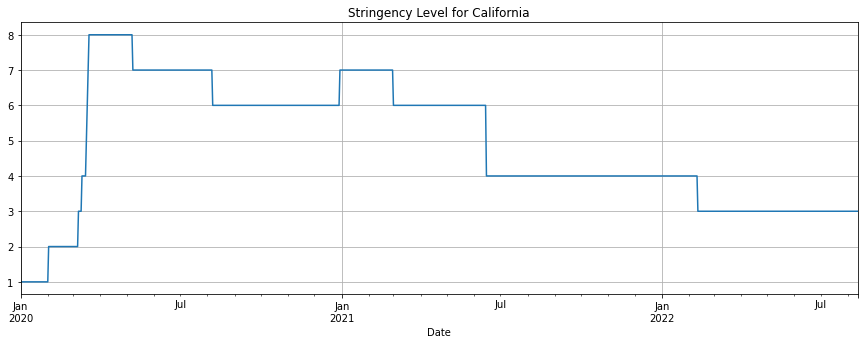

In [10]:
# Visualize the stringency level for a specified US state
state = "California"
policy_df[state].plot(figsize=(15,5), x='Date', title="Stringency Level for {}".format(state), grid=True);

# 2. COVID-19 Federal government subsidies (direct payments) to the states
### Source: Committee For A Responsible Federal Budget
https://www.covidmoneytracker.org/

### Direct payments provided by the Federal Government so far are recorded in this google spreadsheet
https://docs.google.com/spreadsheets/d/1Nr_J5wLfUT4IzqSXkYbdOXrRgEkBxhX0/edit#gid=682404301
### Read as (date: direct payment amount)
2020-04-15: 274B

2020-12-27: 142B

2021-03-11: 386B

In [11]:
subsidy_df = pd.DataFrame(policy_df.index).set_index("Date")
subsidy_df["USA"] = 0.0

subsidy_df.loc["2020-04-15", "USA"] = 274e9
subsidy_df.loc["2020-12-27", "USA"] = 142e9
subsidy_df.loc["2021-03-11", "USA"] = 386e9

# 3. COVID-19 Deaths data
### Source: COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University 
(https://github.com/CSSEGISandData/COVID-19)

In [12]:
deaths_us_df = DatasetCovidDeathsUS(
    data_dir=data_dir,
    download_latest_data=DOWNLOAD_LATEST_DATA
).df

print("COVID-19 death data for the US is available between {} and {}".format(
    deaths_us_df.columns[12], deaths_us_df.columns[-1]))

Fetching latest U.S. COVID-19 deaths data from John Hopkins, and saving it in /home/jupyter/covid19_data/2022-08-12
COVID-19 death data for the US is available between 1/22/20 and 8/11/22


In [13]:
# Retain just the states in US_STATE_ORDER
deaths_us_df = deaths_us_df[deaths_us_df.Province_State.isin(US_STATE_ORDER)]

# We will visualize this later in the notebook

# 4. COVID-19 Vaccination Data
### Source: Our World in Data
(https://ourworldindata.org/covid-vaccinations)

In [14]:
vaccinations_us_df = DatasetCovidVaccinationsUS(
    data_dir=data_dir,
    download_latest_data=DOWNLOAD_LATEST_DATA
).df

vaccination_dates = sorted(vaccinations_us_df.date.unique())
print("Vaccination data is available between {} and {}".format(min(vaccination_dates), max(vaccination_dates)))

Fetching latest U.S. COVID-19 vaccination data from Our World in Data, and saving it in /home/jupyter/covid19_data/2022-08-12
Vaccination data is available between 2020-12-20 and 2022-08-10


In [15]:
vaccinated_df = vaccinations_us_df.pivot(
    index="date", columns="location", values="people_fully_vaccinated"
)[US_STATE_ORDER]

vaccinated_df.index = pd.to_datetime(vaccinated_df.index)
vaccinated_df = vaccinated_df.reindex(COMMON_DATE_INDEX).fillna(0)

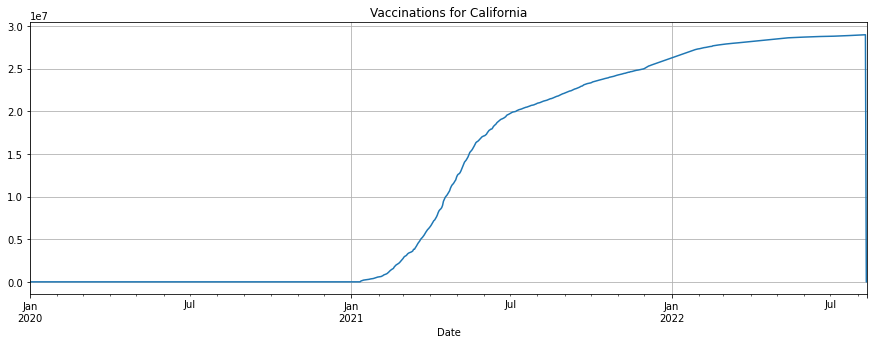

In [16]:
# Visualize the vaccinations for a specified US state
# Warning: the last value may not be updated (may show it to be 0)

state = "California"
vaccinated_df[state].plot(figsize=(15,5), x='Date', title="Vaccinations for {}".format(state), grid=True);

## Using deaths and vaccinations to compute the susceptible-infected-recovered (SIR) numbers

Our SIR data will only treat **deaths** as ground-truth.

Given death data and some assumed constants about the _death rate_ and _recovery rate_ , we can apply some "SIR algebra" (i.e. solve for unknowns using the SIR equations) to _infer_ quantities like total "recovered", number of infected people, and ultimately **Beta**, which is the rate of transmission times the number of people an infected person comes into contact with.

In [17]:
# For data representation, we will want to build a dataframe for...
# ... deaths...
deaths_df = pd.DataFrame(COMMON_DATE_INDEX, columns=['Date']).set_index('Date')
smoothed_deaths_df = pd.DataFrame(COMMON_DATE_INDEX, columns=['Date']).set_index('Date')
# ... (inferred) SIR states...
susceptible_df = pd.DataFrame(COMMON_DATE_INDEX, columns=['Date']).set_index('Date')
infected_df    = pd.DataFrame(COMMON_DATE_INDEX, columns=['Date']).set_index('Date')
recovered_df   = pd.DataFrame(COMMON_DATE_INDEX, columns=['Date']).set_index('Date')
# ... and (inferred) Beta.
beta_df = pd.DataFrame(COMMON_DATE_INDEX, columns=['Date']).set_index('Date')

In [18]:
# STD of the Gaussian smoothing window applied to the death data.
SIR_SMOOTHING_STD = 10

In [19]:
# Fill the death dataframe from (smoothed) raw data

def smooth(x, gauss_std=10):
    """
    gauss_std: standard deviation of the Gaussian smoothing window applied to the death data.
    """
    if gauss_std <= 0:
        return x
    # To invalidate the near-edge results, bookend the input x with nans
    x = np.concatenate([[np.nan], np.array(x), [np.nan]])
    
    kernel = scipy.stats.norm.pdf(
        np.linspace(-3*gauss_std, 3*gauss_std, 1+6*gauss_std),
        scale=gauss_std
    )
    normer = np.ones_like(x)
    smoothed_x = convolve(x, kernel, mode='same') / convolve(normer, kernel, mode='same')
    
    # Remove the indices added by the nan padding
    return smoothed_x[1:-1]

for us_state_name in US_STATE_ORDER:
    state_deaths = deaths_us_df[deaths_us_df['Province_State']==us_state_name]
    cumulative_state_deaths = []
    for d in COMMON_DATE_INDEX:
        date_string = '{d.month}/{d.day}/{y}'.format(d=d, y=d.year % 2000)
        if date_string in state_deaths:
            cumulative_state_deaths.append(
                state_deaths[date_string].sum()
            )
        else:
            cumulative_state_deaths.append(
                np.nan
            )
            
    # Store raw numbers (for direct comparison)
    deaths_df[us_state_name] = cumulative_state_deaths
    
    # Store smoothed numbers (for beta analysis)
    smoothed_cumulative_state_deaths = smooth(cumulative_state_deaths, gauss_std=SIR_SMOOTHING_STD)
    smoothed_deaths_df[us_state_name] = smoothed_cumulative_state_deaths

In [20]:
state_deaths = deaths_us_df[deaths_us_df['Province_State']=="California"]
cumulative_state_deaths = []
for d in COMMON_DATE_INDEX:
    date_string = '{d.month}/{d.day}/{y}'.format(d=d, y=d.year % 2000)
    if date_string in state_deaths:
        cumulative_state_deaths.append(
            state_deaths[date_string].sum()
        )
    else:
        cumulative_state_deaths.append(
            np.nan
        )

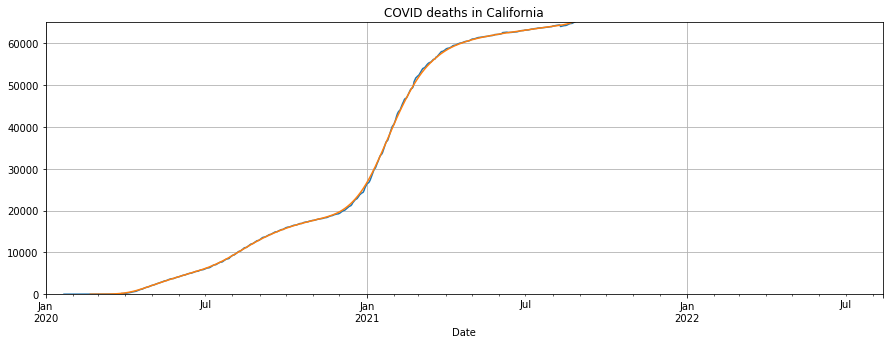

In [21]:
# Visualize the deaths for a specified US state
state = "California"

# Some values near the ends may be "missing" because of smoothing
deaths_df[state].plot(figsize=(15,5), x='Date', ylim=[0, 65000]);
smoothed_deaths_df[state].plot(figsize=(15,5), x='Date', title="COVID deaths in {}".format(state), ylim=[0, 65000], grid=True);

In [22]:
# Death rate: fraction of infected persons who die
SIR_MORTALITY = 0.02

# Recovery rate: the inverse of expected time someone remains infected
SIR_GAMMA = 1 / 14

In [23]:
# This is the core "SIR algebra" used to infer S, I, R, and Beta at each date.

def infer_sir_and_beta(us_state_name):
    state_population = deaths_us_df[deaths_us_df['Province_State']==us_state_name]['Population'].sum()
    
    # Helpful to do this math in normalized numbers
    dead = np.array(smoothed_deaths_df[us_state_name]) / state_population
    vaccinated = np.array(vaccinated_df[us_state_name]) / state_population
    
    # Dead is the fraction of "recovered" that did not survive
    # Also, the vaccinated lot is part of the recovered
    recovered = dead / SIR_MORTALITY + vaccinated
    
    # The daily change in recovered (ignoring the vaccinated) is a fraction of the infected population on the previous day
    infected = np.nan * np.zeros_like(dead)
    infected[:-1] = (recovered[1:] - recovered[:-1] - (vaccinated[1:] - vaccinated[:-1])) / SIR_GAMMA
    
    # S+I+R must always = 1
    susceptible = 1 - infected - recovered
    
    # Here's where things get interesting. The change in infected is due to...
    change_in_i = infected[1:] - infected[:-1]
    # ... infected people that transition to the recovered state (decreases I)...
    expected_change_from_recovery = -infected[:-1] * SIR_GAMMA
    # ... and susceptible people that transition to the infected state (increases I).
    new_infections = change_in_i - expected_change_from_recovery
    
    # With these pieces, we can solve for Beta.
    beta_ = new_infections / (infected[:-1] * susceptible[:-1] + 1e-6)
    beta_ = np.clip(beta_, 0, 1)
    # Apply a threshold in terms of normalized daily deaths (if too low, beta estimates are bad)
    normalized_daily_deaths = dead[1:]-dead[:-1]
    ndd_lookback = np.zeros_like(new_infections)
    lookback_window = 3*SIR_SMOOTHING_STD
    ndd_cutoff = 1e-8
    ndd_lookback[lookback_window:] = normalized_daily_deaths[:-lookback_window]
    beta_[np.logical_not(ndd_lookback > 1e-8)] = np.nan
    
    beta = np.nan * np.zeros_like(dead)
    beta[:-1] = beta_
    
    # Undo normalization
    susceptible *= state_population
    infected    *= state_population
    recovered   *= state_population
    
    return susceptible, infected, recovered, beta

In [24]:
# Fill the SIR and Beta dataframes with their inferred values
for st in US_STATE_ORDER:
    susceptible_df[st], infected_df[st], recovered_df[st], beta_df[st] = infer_sir_and_beta(us_state_name=st)

In [25]:
## Visualize the SIR and BETA for a specified US state
# Warning: some values near the ends may be "missing" because of smoothing

state = "California"

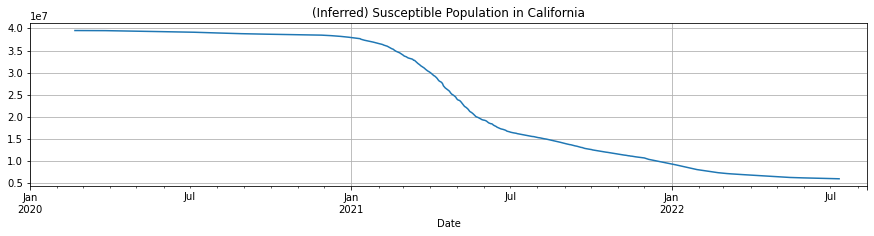

In [26]:
susceptible_df[state].plot(figsize=(15,3), x='Date', title="(Inferred) Susceptible Population in {}".format(state), grid=True);

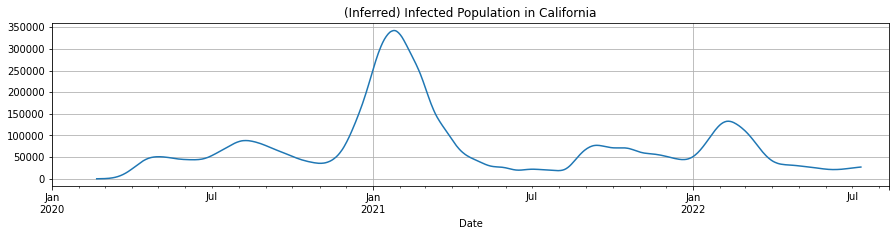

In [27]:
infected_df[state].plot(figsize=(15,3), x='Date', title="(Inferred) Infected Population in {}".format(state), grid=True);

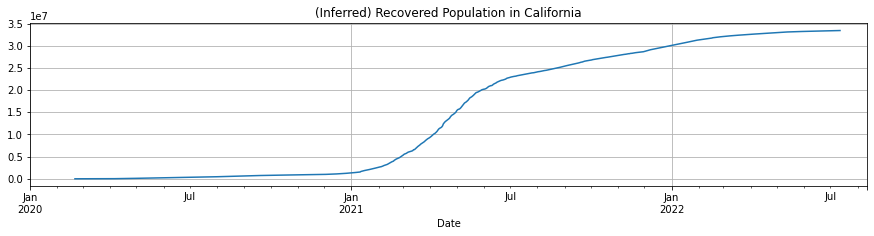

In [28]:
recovered_df[state].plot(figsize=(15,3), x='Date', title="(Inferred) Recovered Population in {}".format(state), grid=True);

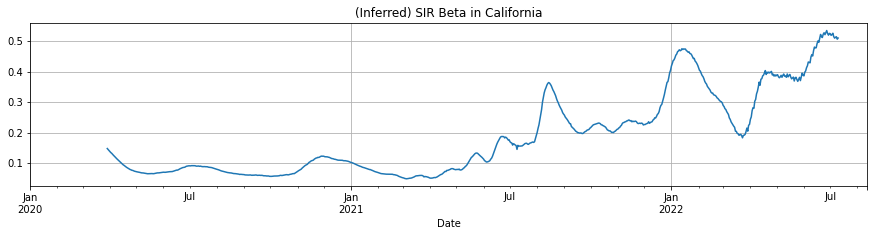

In [29]:
beta_df[state].plot(figsize=(15,3), x='Date', title="(Inferred) SIR Beta in {}".format(state), grid=True);

# 5. COVID-19 Unemployment data
### Source: Bureau of Labor and Statistics

https://www.bls.gov/lau/

In [30]:
monthly_unemployment_us = DatasetCovidUnemploymentUS(
    data_dir=data_dir,
    download_latest_data=DOWNLOAD_LATEST_DATA).data

/home/jupyter/.local/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


Fetching the U.S. unemployment data from Bureau of Labor and Statistics, and saving it in /home/jupyter/covid19_data/2022-08-12
Getting BLS Data. This might take a minute...


In [31]:
sample_monthly_unemployment = monthly_unemployment_us['California']
unemp_year_keys = sorted(sample_monthly_unemployment.keys())
unemp_starting_month_key = sorted(sample_monthly_unemployment[unemp_year_keys[0]].keys())[0]
unemp_ending_month_key = sorted(sample_monthly_unemployment[unemp_year_keys[-1]].keys())[-1]
unemp_starting_date = datetime.strptime(
    str(unemp_year_keys[0]) + '-' + str(unemp_ending_month_key+1) + '-1', DATE_FORMAT)
unemp_ending_date = datetime.strptime(
    str(unemp_year_keys[-1]) + '-' + str(unemp_ending_month_key+1) + '-1', DATE_FORMAT) - timedelta(1)

print("Unemployment data is available between {} and {}".format(datetime.strftime(unemp_starting_date, DATE_FORMAT),
                                                                datetime.strftime(unemp_ending_date, DATE_FORMAT)))

Unemployment data is available between 2012-07-01 and 2022-06-30


In [32]:
# Convert this to a daily unemployment dataframe

unemployment_df = pd.DataFrame(COMMON_DATE_INDEX, columns=['Date']).set_index('Date')

for us_state_name in monthly_unemployment_us.keys():
    unemployment_df[us_state_name] = [
        monthly_unemployment_us[us_state_name][x.year].get(x.month, np.nan)
        for x in unemployment_df.index
    ]
unemployment_df = unemployment_df[US_STATE_ORDER]

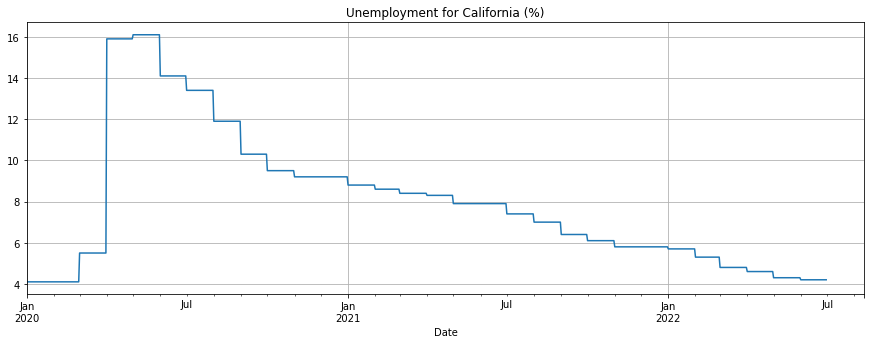

In [33]:
## Visualize the unemployment rate for a specified US state
# There is likely going to be some unemployment data missing at the tail end, 
# as the unemployment data isn't updated as frequently as the other data.

state = "California"
unemployment_df[state].plot(figsize=(15,5), x='Date', title="Unemployment for {} (%)".format(state), grid=True);

### Unemployment rate -> unemployed (the number of unemployed people)

In [34]:
us_state_to_pop_dict = {}
for us_state in US_STATE_ORDER:
    us_state_to_pop_dict[us_state] = deaths_us_df[deaths_us_df.Province_State==us_state].Population.sum()

In [35]:
unemployed_df = unemployment_df.multiply([us_state_to_pop_dict[col]/100.0 for col in unemployment_df.columns])

## Saving

### Save some of the data processing constants for use within the environment

In [36]:
model_constants_dict = {}

model_constants_dict["DATE_FORMAT"] = DATE_FORMAT
model_constants_dict["STRINGENCY_POLICY_KEY"] = STRINGENCY_POLICY_KEY
model_constants_dict["NUM_STRINGENCY_LEVELS"] = int(NUM_STRINGENCY_LEVELS)
model_constants_dict["SIR_SMOOTHING_STD"] = SIR_SMOOTHING_STD
model_constants_dict["SIR_MORTALITY"] = SIR_MORTALITY
model_constants_dict["SIR_GAMMA"] = SIR_GAMMA
model_constants_dict["US_STATE_IDX_TO_STATE_NAME"] = {
    us_state_idx: us_state for us_state_idx, us_state in enumerate(US_STATE_ORDER)
}
model_constants_dict["US_STATE_POPULATION"] = [int(us_state_to_pop_dict[us_state]) for us_state in US_STATE_ORDER]
model_constants_dict["US_POPULATION"] = int(sum([us_state_to_pop_dict[us_state] for us_state in US_STATE_ORDER]))

# 2019: https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=US&view=chart
model_constants_dict["GDP_PER_CAPITA"] = 65300  # TODO: Load this in from model_constants.json.

model_constants_filename = "model_constants.json"
with open(os.path.join(data_dir, model_constants_filename), "w") as fp: 
    json.dump(model_constants_dict, fp)

### Save all the processed dataframes in order to use for model fitting notebook (fit_model_parameters.ipynb)

In [37]:
dataframes = {
    "policy": policy_df,
    "subsidy": subsidy_df,
    "deaths": deaths_df,
    "vaccinated": vaccinated_df,
    "smoothed_deaths": smoothed_deaths_df,
    "susceptible": susceptible_df,
    "infected": infected_df,
    "recovered": recovered_df,
    "beta": beta_df,
    "unemployment": unemployment_df,
    "unemployed": unemployed_df,
}

for k, df in dataframes.items():
    if k == "subsidy":  # This is at the USA level, not at the US states level
        continue
    assert (df.columns.to_list() == US_STATE_ORDER).all()

with open(os.path.join(data_dir, 'dataframes.pkl'), 'wb') as F:
    pickle.dump(dataframes, F)

### Also save all the data as numpy arrays for use within the covid19 simulation environment

In [38]:
real_world_data = {}
for key in dataframes:
    real_world_data[key] = dataframes[key].values
    
# Save the real-world data as a .npz for use within the environment
np.savez(os.path.join(data_dir, "real_world_data.npz"), **real_world_data)    

## Finally, in order to use this gathered real-world data when you run the covid19 simulation, you will need to also

### 1. Run the "fit_model_parameters.ipynb" notebook with the base data directory specified below.

In [39]:
print("BASE_DATA_DIR_PATH = '{}'".format(BASE_DATA_DIR_PATH))

BASE_DATA_DIR_PATH = '/home/jupyter/covid19_data'


### 2. Set "path_to_data_and_fitted_params" in the env config also to the data directory below.

In [40]:
print("path_to_data_and_fitted_params = '{}'".format(data_dir))

path_to_data_and_fitted_params = '/home/jupyter/covid19_data/2022-08-12'
